In [1]:
%matplotlib inline

import sqlite3
import cbor2
import json
import matplotlib.pyplot as plt
import math
import scipy.stats
import numpy as np
import pandas as pd
import networkx as nx
import multiprocessing as mp
import time
import os
import IPython.display

# `objdump` stats analysis

In [2]:
def make_connection(i):
    assert i >= 0 and i <= 9
    return sqlite3.connect(f'13022020statsobjdump0objdump{i}_data-vol/_data/collab/out/run_info.sqlite')

In [3]:
# get time of test handle from test_cases
# time to crack all condition branches from observed_conditions analysis dump                
# finally check correlation btw time to flip all branches of condition and "difficulty" (inst count)
# NB do not consider conditions in 'observed_conditions' if inst count is zero

def count_set_bits(arr, sz):
    c = 0
    for i in range(sz):
        idx = math.floor(i / 32)
        b = arr[idx]
        check = 1 << (i % 32)
        if b & check == check:
            c += 1
        else:
            return 0
    return c

def print_stats(obs):
    print('\tDescribe:', scipy.stats.describe(obs))
    print('\tNormality test:', *scipy.stats.normaltest(obs))

def _time_to_crack_to_inst_count_analysis(dbn, use_inst_count_max=False, silent=False):
    conn = make_connection(dbn)
    
    # get instruction counts per condition for this run
    cursor = conn.execute(
        'SELECT s.analysis_dump '
        'FROM analysis_states s '
        'JOIN analysis_types t ON s.analysis_id = t.id '
        'WHERE t.description = "instruction_count";')
    analysis_dump = cursor.fetchall()

    # de-serialize cbor
    inst_counts = list(map(lambda row: cbor2.loads(row[0]), analysis_dump))
    if not silent:
        print(f'Instruction count analysis has {len(inst_counts)} items')
    
    # process instruction counts (N.B. using the max seen does not make sense)
    inst_counts_comp = {}
    if use_inst_count_max:
        for i in inst_counts:
            for j in i:
                id = int(j['id'])
                if id not in inst_counts_comp:
                    inst_counts_comp[id] = j['count']
    else:
        for i in inst_counts:
            for j in i:
                inst_counts_comp[int(j['id'])] = j['count']

    # plot histogram of instruction counts per condition
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 3)
    max_inst_count = max(inst_counts_comp.values())
    ax.hist(inst_counts_comp.values(), color='k', bins=max_inst_count)
    ax.set_xticks(range(max_inst_count + 1))
    ax.set_xlabel('Instruction count')
    fig.tight_layout()
    fig.savefig(f'inst_count_histo_{dbn}{"_max" if use_inst_count_max else ""}.pdf', bbox_inches='tight')
    
    # get observed conditions analysis
    cursor = conn.execute(
        'SELECT tc.discovery_time, s.analysis_dump '
        'FROM analysis_states s '
        'JOIN test_cases tc ON s.test_case_hash = tc.hash '
        'JOIN analysis_types t ON s.analysis_id = t.id '
        'WHERE t.description = "observed_conditions";')
    
    observed_conditions = [{
        'time': r[0],
        'dump': cbor2.loads(r[1])
    } for r in cursor.fetchall()]

    # build a dictionary mapping conditions to list of discovery times where
    # all branches were visited
    cracked_conditions = {}
    total_obs = 0
    for oc in observed_conditions:
        discovery_time = oc['time']
        assert discovery_time > 0, f'discovery time is {discovery_time}'
        for o in oc['dump']:
            cond_id = o['id']
            total_obs += 1
            os = o['observed_states']
            if count_set_bits(os[1], os[0]) == os[0]:
                if cond_id in cracked_conditions:
                    cracked_conditions[cond_id].append(discovery_time)
                else:
                    cracked_conditions[cond_id] = [discovery_time]

    # delete early to avoid OOM
    del observed_conditions
    if not silent:
        print(f'Total observations {total_obs}')

    # build dictionary mapping conditions to the minimum time to visit all branches
    cond_min_time = {
        cond_id: (np.array(times).min(),
                  inst_counts_comp[cond_id] if cond_id in inst_counts_comp else None)
        for cond_id, times in cracked_conditions.items()
    }

    ts, ics = [], []
    for t, ic in cond_min_time.values():
        if ic is None:
            continue
        ts.append(t)
        ics.append(ic)
        
    pearsonr = scipy.stats.pearsonr(ts, ics)
    if not silent:
        print(f'Time to crack all branches stats:')
        print_stats(ts)
        print('Instruction counts stats:')
        print_stats(ics)
        print('Pearson', *pearsonr)
        print('Spearman', *scipy.stats.spearmanr(ts, ics))
        print('Kendall', *scipy.stats.kendalltau(ts, ics))
    
    return {
        'times': ts,
        'inst_counts': ics,
        'pearson_c': pearsonr[0],
        'pearson_p': pearsonr[1]
    }

# same as above but does it separately by fuzzer instead of globally
def _time_to_crack_to_inst_count_analysis_per_fuzzer(dbn):
    with make_connection(dbn) as conn:
        cursor = conn.execute(
            'SELECT s.analysis_dump '
            'FROM analysis_states s '
            'JOIN analysis_types t ON s.analysis_id = t.id '
            'WHERE t.description = "instruction_count";')
        inst_counts = [cbor2.loads(row[0]) for row in cursor.fetchall()]
        inst_counts_comp = {}
        for i in inst_counts:
            for j in i:
                inst_counts_comp[int(j['id'])] = j['count']
        
        cursor = conn.execute(
            'SELECT tc.discovery_fuzzer, tc.discovery_time, s.analysis_dump '
            'FROM analysis_states s '
            'JOIN test_cases tc ON s.test_case_hash = tc.hash '
            'JOIN analysis_types t ON s.analysis_id = t.id '
            'WHERE t.description = "observed_conditions";')
        observed_conditions = [{
            'fuzzer_id': r[0],
            'time': r[1],
            'dump': cbor2.loads(r[2])
        } for r in cursor.fetchall()]
        
        cracked_conditions = {}
        total_obs = 0
        for oc in observed_conditions:
            discovery_time = oc['time']
            discovery_fuzzer = oc['fuzzer_id']
            if discovery_fuzzer not in cracked_conditions:
                cracked_conditions[discovery_fuzzer] = {}
            assert discovery_time > 0, f'discovery time is {discovery_time}'
            for o in oc['dump']:
                cond_id = o['id']
                total_obs += 1
                os = o['observed_states']
                if count_set_bits(os[1], os[0]) == os[0]:
                    if cond_id in cracked_conditions[discovery_fuzzer]:
                        cracked_conditions[discovery_fuzzer][cond_id].append(discovery_time)
                    else:
                        cracked_conditions[discovery_fuzzer][cond_id] = [discovery_time]
        del observed_conditions
        
        cracked_conditions_min = {}
        for fuzzer, cond_dict in cracked_conditions.items():
            cracked_conditions_min[fuzzer] = {}
            for cond_id, times in cond_dict.items():
                cracked_conditions_min[fuzzer][cond_id] = min(times)
        del cracked_conditions

        result = {}
        for fuzzer, cond_dict in cracked_conditions_min.items():
            result[fuzzer] = { 'costs': [], 'times': [] }
            for cond_id, min_time in cond_dict.items():
                if cond_id not in inst_counts_comp:
                    continue
                cost = inst_counts_comp[cond_id]
                result[fuzzer]['times'].append(min_time)
                result[fuzzer]['costs'].append(cost)
            # r = scipy.stats.pearsonr(fuzzer_times, fuzzer_costs)
            # print('fuzzer {} has PCC {:.4f} (p-val {:.4f})'.format(fuzzer, r[0], r[1]))
        return result
        
def run_time_to_crack_to_inst_count_analysis(use_max, pool_size=mp.cpu_count() // 2):
    with mp.Pool(pool_size) as pool:
        results = pool.starmap(_time_to_crack_to_inst_count_analysis, [(i, use_max, True) for i in range(10)])
    return results

def run_time_to_crack_to_inst_count_analysis_per_fuzzer(pool_size=mp.cpu_count() // 2):
    with mp.Pool(pool_size) as pool:
        results = pool.starmap(_time_to_crack_to_inst_count_analysis_per_fuzzer, [(i, ) for i in range(10)])
    agg_res = {}
    for i, res in enumerate(results):
        print('run', i)
        for fuzzer, values_dict in res.items():
            if fuzzer not in agg_res:
                agg_res[fuzzer] = { 'costs': [], 'times': [] }
            agg_res[fuzzer]['costs'] += values_dict['costs']
            agg_res[fuzzer]['times'] += values_dict['times']
            r = scipy.stats.pearsonr(values_dict['costs'], values_dict['times'])
            print('fuzzer {} has PCC {:.4f} (p-val {:.4f})'.format(fuzzer, r[0], r[1]))
        print()
    # for fuzzer, values_dict in agg_res.items():
        # r = scipy.stats.pearsonr(values_dict['times'], values_dict['costs'])
        # print('fuzzer {} has PCC {:.4f} (p-val {:.4f})'.format(fuzzer, r[0], r[1]))

def get_time_to_crack_to_inst_count_analysis_dfs(results):
    df_correlations = pd.DataFrame.from_records([(r['pearson_c'], r['pearson_p']) for r in results], columns=['coeff', 'p-val'])
    all_times = []
    all_inst_counts = []
    for r in results:
        all_times += r['times']
        all_inst_counts += r['inst_counts']
    df_data = pd.DataFrame.from_dict(dict(times=all_times, inst_counts=all_inst_counts))
    return df_correlations, df_data

def time_to_crack_to_inst_count_analysis(use_max, force_compute=False):
    data_ar_str = 'inst_count_cond_times.tar.gz'
    coeff_ar_str = 'inst_count_cond_times_coeff.tar.gz'
    if force_compute or not os.path.exists(data_ar_str) or not os.path.exists(coeff_ar_str):
        runs_data = run_time_to_crack_to_inst_count_analysis(use_max)
        df_correlations, df_data = get_time_to_crack_to_inst_count_analysis_dfs(runs_data)
        df_correlations.to_pickle(coeff_ar_str)
        df_data.to_pickle(data_ar_str)
    else:
        df_correlations = pd.read_pickle(coeff_ar_str)
        df_data = pd.read_pickle(data_ar_str)
    return df_correlations, df_data

run_time_to_crack_to_inst_count_analysis_per_fuzzer(pool_size=4)

run 0
fuzzer 778357658 has PCC 0.0180 (p-val 0.7663)
fuzzer 1381893747 has PCC -0.0633 (p-val 0.3234)
fuzzer 1040678757 has PCC 0.1352 (p-val 0.0090)
fuzzer 1536795865 has PCC 0.2113 (p-val 0.0012)

run 1
fuzzer 1501399617 has PCC 0.5569 (p-val 0.0000)
fuzzer 2057941418 has PCC 0.4767 (p-val 0.0000)
fuzzer 1741271729 has PCC 0.2919 (p-val 0.0000)
fuzzer 241074191 has PCC 0.0730 (p-val 0.4206)

run 2
fuzzer 3442062947 has PCC 0.0045 (p-val 0.9298)
fuzzer 4078090948 has PCC 0.2968 (p-val 0.0000)
fuzzer 3281284222 has PCC 0.3305 (p-val 0.0000)
fuzzer 1227556350 has PCC 0.2234 (p-val 0.0003)

run 3
fuzzer 1532210852 has PCC 0.1005 (p-val 0.0888)
fuzzer 1509140520 has PCC 0.0887 (p-val 0.0861)
fuzzer 2988277198 has PCC 0.1095 (p-val 0.0537)
fuzzer 2096926472 has PCC 0.2248 (p-val 0.0004)

run 4
fuzzer 2514047252 has PCC -0.1081 (p-val 0.0430)
fuzzer 1039521051 has PCC 0.2640 (p-val 0.0000)
fuzzer 1403966425 has PCC 0.4281 (p-val 0.0000)
fuzzer 4019808560 has PCC 0.2537 (p-val 0.0001)

run 5

# Instruction count analysis

Produce histograms for the instruction counts (saved to file) and compute correlation coefficients for the instruction count to tainted conditions and time to visit all branches of such conditions; return two data frames with coefficients per runs and raw data:

- one contains the (Pearsons) correlation coefficients and respective p-value for each analysed run;

- the other contains the data used for the analysis for all runs in the same data frame

In [4]:
df_corr_og, df_data_og = time_to_crack_to_inst_count_analysis(use_max=False)

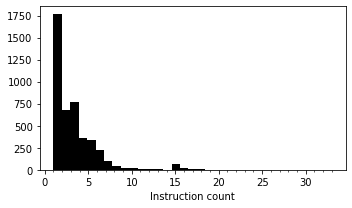

In [5]:
def plot_inst_count_histo_all_runs(df):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 3)
    mx = df.max()
    ax.hist(df, color='k', bins=mx)
    ax.set_xticks(range(0, mx+1), minor=True)
    ax.set_xlabel('Instruction count')
    fig.tight_layout()
    
plot_inst_count_histo_all_runs(df_data_og.inst_counts)

In [6]:
# display stored images inline
# for i in range(10):
#     IPython.display.display(IPython.display.Image(f'inst_count_histo_{i}.pdf'))

## Correlation coefficients

### Correlation per run

In [7]:
df_corr_og

,coeff,p-val
0,0.106869,2.815280e-02
1,0.522986,5.072103e-30
2,0.194436,1.243156e-05
3,0.053936,2.589044e-01
4,0.327763,1.749510e-13
5,0.026053,5.904847e-01
6,0.257136,1.778546e-07
7,0.113078,1.858539e-02
8,0.370348,4.736745e-17
9,0.407916,8.627467e-20


In [8]:
for row in df_corr_og.itertuples():
    print('{:.3f} {:.3f} {}'.format(row.coeff, row._2, 'reject non corr' if row._2 < 0.05 else 'cannot reject'))

0.107 0.028 reject non corr
0.523 0.000 reject non corr
0.194 0.000 reject non corr
0.054 0.259 cannot reject
0.328 0.000 reject non corr
0.026 0.590 cannot reject
0.257 0.000 reject non corr
0.113 0.019 reject non corr
0.370 0.000 reject non corr
0.408 0.000 reject non corr


The mean of the correlation *per run* is $0.238$; not that bad. The standard deviation is not so low though at $0.167$.

In [9]:
df_corr_og.loc[:, 'coeff'].describe()

count    10.000000
mean      0.238052
std       0.166509
min       0.026053
25%       0.108421
50%       0.225786
75%       0.359702
max       0.522986
Name: coeff, dtype: float64

### Correlation of data across runs

Following is the correlation of instruction count with time to visit all conditions, aggregated across all 10 runs.

In [10]:
df_data_og_coeff, df_data_og_coeff_p = scipy.stats.pearsonr(df_data_og.loc[:, 'times'],
                                                            df_data_og.loc[:, 'inst_counts'])
print('Pearson coefficient across all runs: {:.4f} {:.4f} {}'.format(df_data_og_coeff, df_data_og_coeff_p, 'rej non corr' if df_data_og_coeff_p < 0.05 else 'cannot rej non corr'))

Pearson coefficient across all runs: 0.2090 0.0000 rej non corr


### Stats on the times to visit all branches of seen conditions and instruction counts

In [11]:
df_data_og.describe()

,times,inst_counts
count,4449.000000,4449.000000
mean,7891.226793,2.996853
std,8573.088125,2.875409
min,3.000000,1.000000
25%,1511.000000,1.000000
50%,4694.000000,2.000000
75%,11058.000000,4.000000
max,36033.000000,33.000000


In [12]:
def test_normality(data, alpha=.1e-3):
    s, p = scipy.stats.normaltest(data)
    # null hypothesis: data is normal
    if p < alpha:
        return True, p  # reject null hypothesis
    else:
        return False, p # null hypothesis cannot be rejected

for col in df_data_og.columns:
    rej_normality, p = test_normality(df_data_og.loc[:, col])
    print('"{}" {} normal (p-value {})'.format(col, 'is not' if rej_normality else 'is', p))


"times" is not normal (p-value 2.8670314446151757e-255)
"inst_counts" is not normal (p-value 0.0)


# Can instruction count be used to build a regressor for the time to visit all branches?

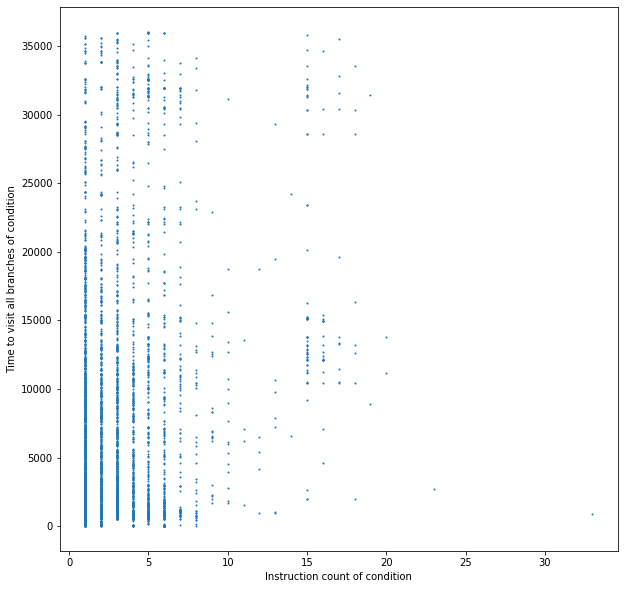

In [13]:
def plot_inst_count_per_time(df):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    y = df.loc[:, 'times'].to_numpy()
    x = df.loc[:, 'inst_counts'].to_numpy()
    ax.scatter(x, y, s=1)
    ax.set_ylabel('Time to visit all branches of condition')
    ax.set_xlabel('Instruction count of condition')

plot_inst_count_per_time(df_data_og)

Not really much to say about this.. Seems like for lower instruction counts, the time has really high variability, while for the upper counts, there seems to be two modes in the distribution of times.

Let's split the dataset in two: one with instruction count less than 12 and one with the rest and check the variance of time.

In [14]:
split_inst_count_at = 11
df_data_og.loc[df_data_og.inst_counts.lt(split_inst_count_at), 'times'].describe()

count     4319.000000
mean      7647.327159
std       8431.342462
min          3.000000
25%       1473.000000
50%       4526.000000
75%      10563.000000
max      36033.000000
Name: times, dtype: float64

In [15]:
df_data_og.loc[df_data_og.inst_counts.ge(split_inst_count_at), 'times'].describe()

count      130.000000
mean     15994.323077
std       9305.190096
min        852.000000
25%      11194.500000
50%      13211.000000
75%      19557.500000
max      35842.000000
Name: times, dtype: float64

Let's try a boxplot for each value of instruction count in the hope to better visualize the variability of times

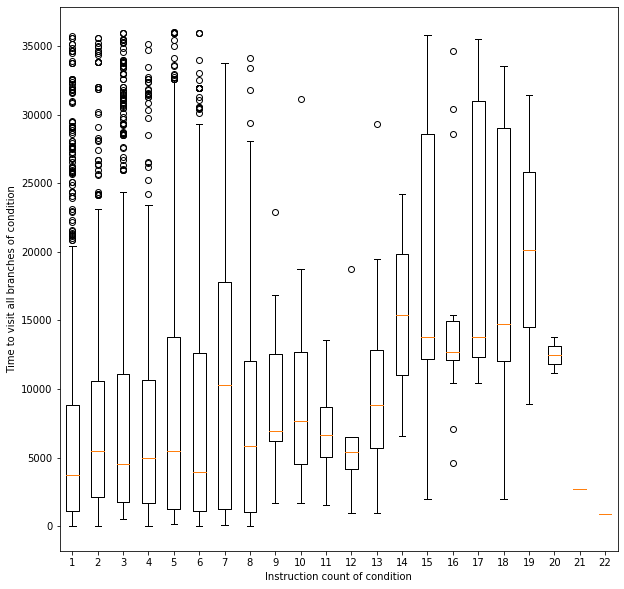

In [16]:
def plot_inst_count_per_time_boxplot(df):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    data = [[x.times for x in g.itertuples()] for _, g in df.groupby('inst_counts', sort=True)]
    ax.boxplot(data)
    ax.set_ylabel('Time to visit all branches of condition')
    ax.set_xlabel('Instruction count of condition')

plot_inst_count_per_time_boxplot(df_data_og)

This is not so bad: there is not so much variance for low instruction counts and the positive (weak) correlation is somewhat visible.

## Test some ML models

Finally let's try some common models for regression and plot the validation results (on $25\%$ of the dataset) for the model instance with parameters given by a simple grid search. 

svr {'svr__C': 1000.0, 'svr__gamma': 0.01}
nusvr {'nusvr__C': 10000.0, 'nusvr__gamma': 10.0}
tree {'decisiontreeregressor__criterion': 'mse', 'decisiontreeregressor__min_samples_leaf': 32}


/home/acidghost/.virtualenvs/collab-fuzz/lib/python3.8/site-packages/sklearn/model_selection/_search.py:787: RuntimeWarning: overflow encountered in square
  array_stds = np.sqrt(np.average((array -


mlp {'mlpregressor__activation': 'tanh', 'mlpregressor__hidden_layer_sizes': (256,), 'mlpregressor__learning_rate': 'adaptive', 'mlpregressor__learning_rate_init': 0.001, 'mlpregressor__solver': 'sgd'}

svr:fit_time -> mean value is 3.6140
svr:score_time -> mean value is 0.0071
svr:test_neg_mean_absolute_error -> mean value is -5907.9545
svr:test_neg_median_absolute_error -> mean value is -3311.1868
svr:test_neg_root_mean_squared_error -> mean value is -9021.2152
svr:test_neg_mean_squared_log_error -> mean value is -1.9092
svr:test_explained_variance -> mean value is 0.0652
svr:test_max_error -> mean value is -30231.5218

nusvr:fit_time -> mean value is 3.5331
nusvr:score_time -> mean value is 0.0039
nusvr:test_neg_mean_absolute_error -> mean value is -6068.0261
nusvr:test_neg_median_absolute_error -> mean value is -4509.1197
nusvr:test_neg_root_mean_squared_error -> mean value is -8634.1573
nusvr:test_neg_mean_squared_log_error -> mean value is -2.1027
nusvr:test_explained_variance ->

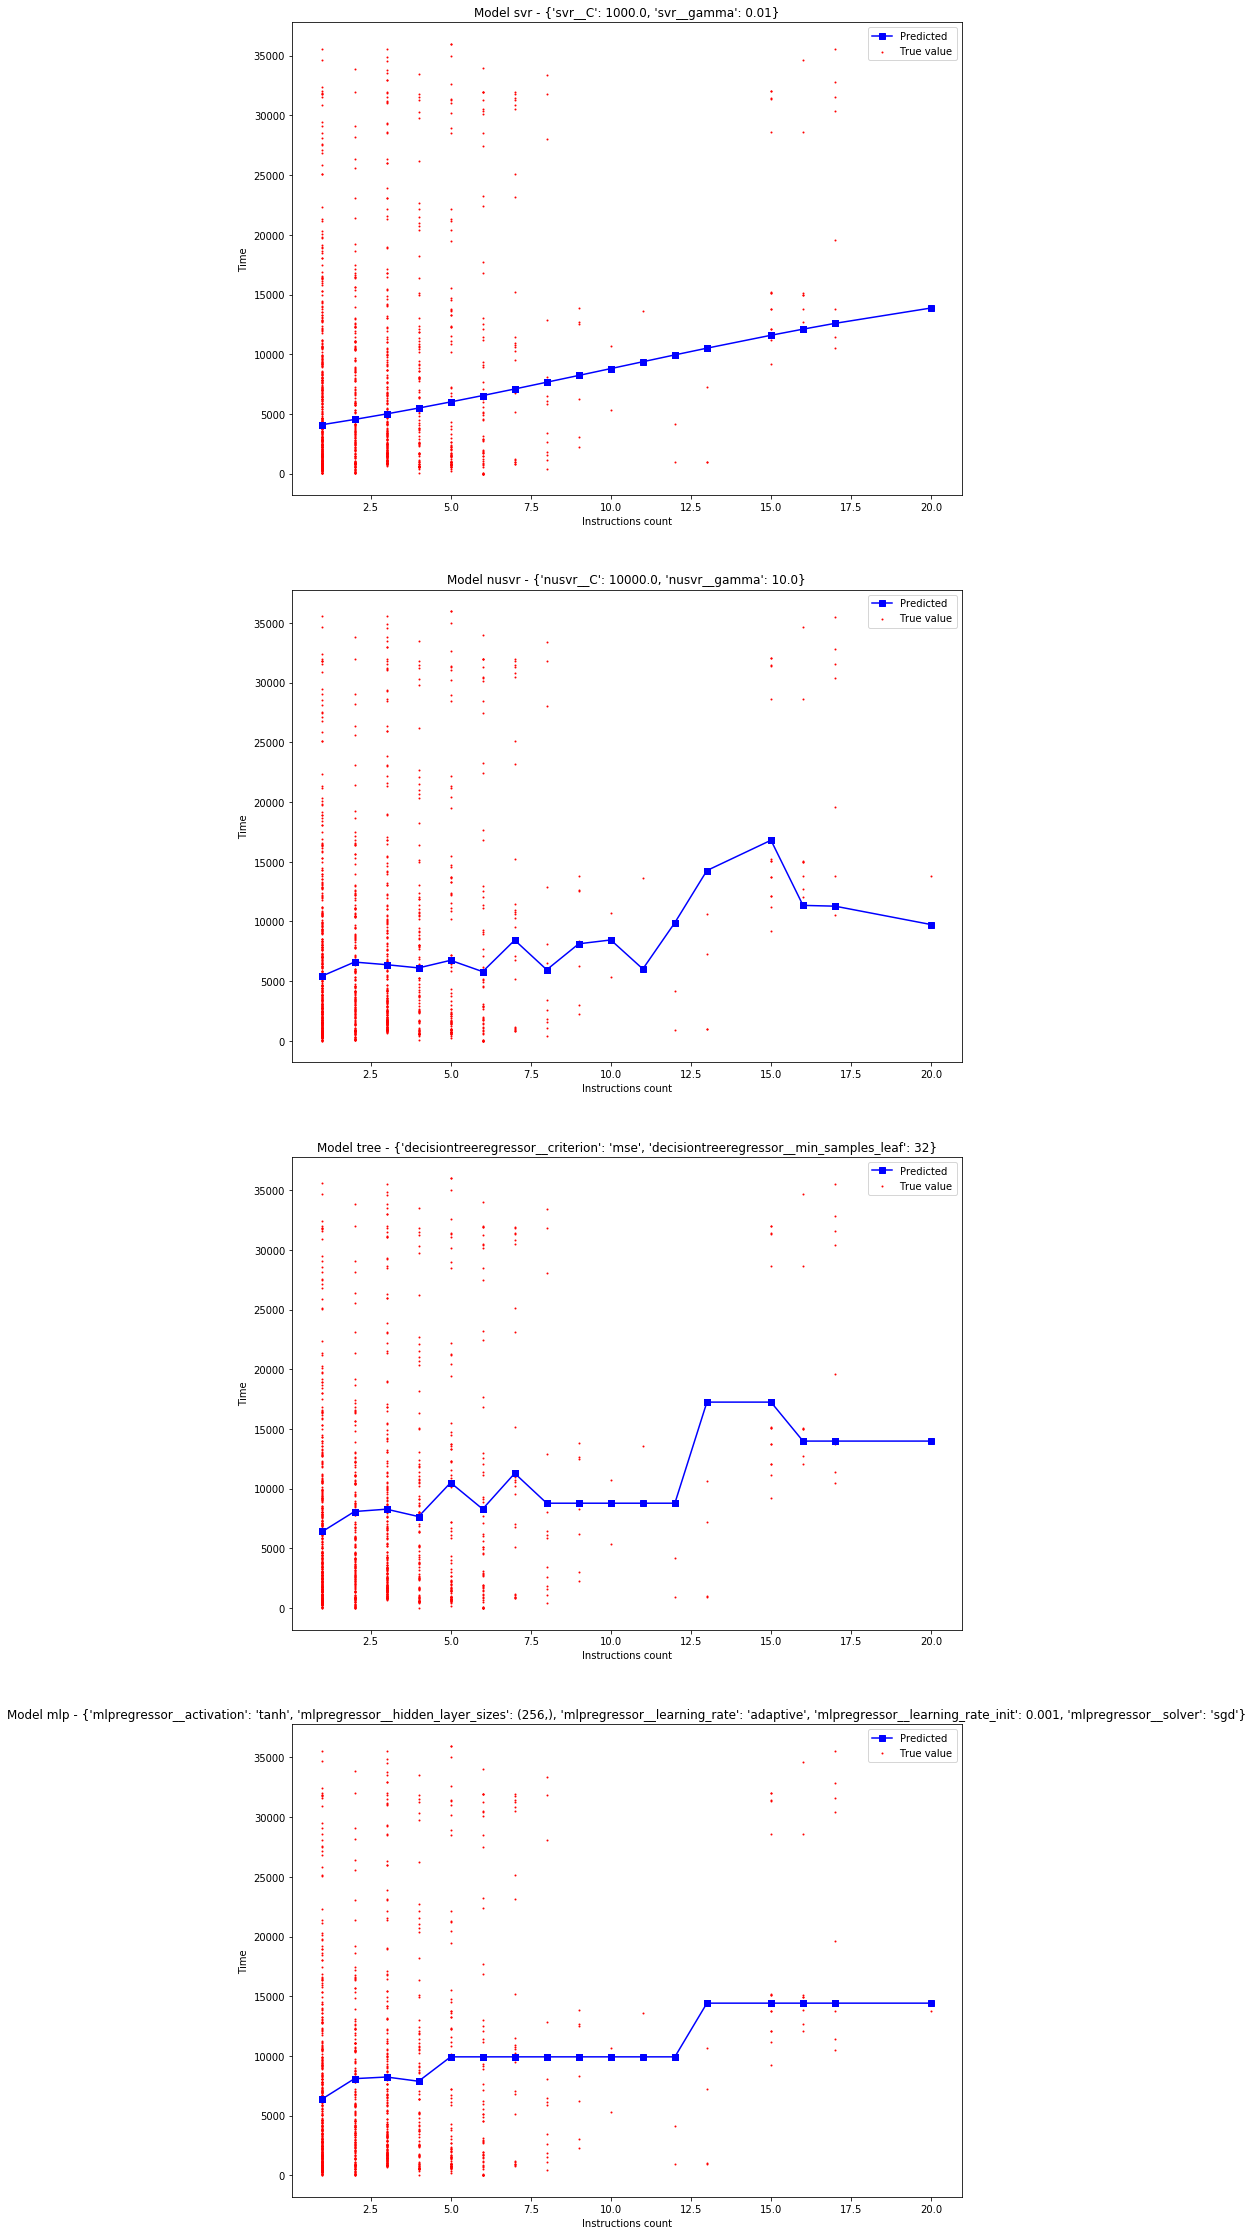

In [17]:
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

def inst_count_time_scale(df):
    X = df.loc[:, 'inst_counts'].to_numpy().reshape(-1, 1)
    y = df.loc[:, 'times'].to_numpy().reshape(-1, 1).ravel()
    scaler = preprocessing.StandardScaler()
    return X, y, scaler

def test_regressor_inst_count_time(X, y, regressor):
    # cv = ShuffleSplit(n_splits=5, random_state=0)
    scoring = ['neg_mean_absolute_error', 'neg_median_absolute_error',
               'neg_root_mean_squared_error', 'neg_mean_squared_log_error',
               'explained_variance', 'max_error']
    return cross_validate(regressor, X, y, scoring=scoring, cv=5, n_jobs=10)

def test_regressors_inst_count_time(df):
    inst_time_regression_models = { 'svr': (svm.SVR(),
                                            { 'svr__C': [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
                                            , 'svr__gamma': np.logspace(-2, 2, 5)
                                            })
                                  , 'nusvr': (svm.NuSVR(),
                                              { 'nusvr__C': [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
                                              , 'nusvr__gamma': np.logspace(-2, 2, 5)
                                              })
                                  , 'tree': (DecisionTreeRegressor(),
                                             { 'decisiontreeregressor__criterion': ('mse', 'mae', 'friedman_mse')
                                             , 'decisiontreeregressor__min_samples_leaf': [2 ** n for n in range(1, 10)]
                                             })
                                  # , 'ridge': (KernelRidge(),
                                  #             { 'kernelridge__kernel': ('rbf', 'poly')
                                  #             , 'kernelridge__gamma': np.logspace(-2, 2, 5)
                                  #             , 'kernelridge__alpha': [1e-2, 1e-1, 1e0, 1e1]
                                  #             })
                                  , 'mlp': (MLPRegressor(max_iter=600),
                                            { 'mlpregressor__hidden_layer_sizes': [(2 ** n, ) for n in range(3, 9)]
                                            , 'mlpregressor__activation': ('tanh', )
                                            , 'mlpregressor__solver': ('sgd', )
                                            , 'mlpregressor__learning_rate': ('adaptive', )
                                            , 'mlpregressor__learning_rate_init': [1e-4, 1e-3, 1e-2]
                                            })
                                  }
    X, y, scaler = inst_count_time_scale(df.dropna())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=True)
    scaler = scaler.fit(X_train)
    
    X_test_perm = X_test.argsort(axis=0)
    X_plot = X_test[X_test_perm].reshape(-1, 1)
    y_plot = y_test[X_test_perm]
    
    fitted_models = {}
    for name, (model, grid_params) in inst_time_regression_models.items():
        pipeline = make_pipeline(scaler, model)
        search = GridSearchCV(pipeline, param_grid=grid_params, n_jobs=10)
        fitted = search.fit(X_train, y_train)
        fitted_models[name] = fitted
        print(name, fitted.cv_results_['params'][fitted.best_index_])
    print()
    
    fig, axs = plt.subplots(len(fitted_models.items()))
    fig.set_size_inches(12, 40)
    for ax, (name, model) in zip(axs, fitted_models.items()):
        scores = test_regressor_inst_count_time(X_test, y_test, model)
        y_hat = model.predict(X_plot)
        ax.set_title(f'Model {name} - {model.cv_results_["params"][model.best_index_]}')
        ax.set_ylabel('Time')
        ax.set_xlabel('Instructions count')
        ax.scatter(X_plot, y_plot, s=1, c='r', marker='o', label='True value')
        ax.plot(X_plot, y_hat, c='b', marker='s', label='Predicted')
        ax.legend(loc='best')
        for scoring_f, ss in scores.items():
            print('{}:{} -> mean value is {:.4f}'.format(name, scoring_f, ss.mean()))
        print()
        
test_regressors_inst_count_time(df_data_og)

# Test Case Benefit analysis

First we load the CFG and check that we have an high number of strongly connected components.

In [18]:
with open('objdump-bb-reach', 'r') as f:
    bb_reach = json.load(f)
bb_reach = dict(bb_reach)

reach_G = nx.DiGraph()
for k, adj in bb_reach.items():
    for n in adj:
        reach_G.add_edge(k, n)
        
print(f'CFG has {len(reach_G.nodes)} nodes and {len(reach_G.edges)} edges')
        
n_strongly_cc = nx.number_strongly_connected_components(reach_G)
n_weakly_cc = nx.number_weakly_connected_components(reach_G)
print(f'CFG has {n_strongly_cc} strongly and {n_weakly_cc} weakly connected components')

CFG has 44189 nodes and 95477 edges
CFG has 22783 strongly and 139 weakly connected components


In [19]:
def parse_benefit(dbn):
    with make_connection(dbn) as conn:
        # following query takes the analyses for each discovered test case necessary
        # to re-compute the benefit in the same way as the schedulers do
        query = ('SELECT tc.discovery_time, s_benefit.analysis_dump, s_cov.analysis_dump '
                 'FROM test_cases tc '
                 'JOIN ('
                 '  SELECT test_case_hash, analysis_dump '
                 '  FROM analysis_states s0 '
                 '  JOIN analysis_types t0 ON s0.analysis_id = t0.id '
                 '  WHERE t0.description = "test_case_benefit"'
                 ') s_benefit ON s_benefit.test_case_hash = tc.hash '
                 'JOIN ('
                 '  SELECT test_case_hash, analysis_dump '
                 '  FROM analysis_states s0 '
                 '  JOIN analysis_types t0 ON s0.analysis_id = t0.id '
                 '  WHERE t0.description = "global_coverage"'
                 ') s_cov ON s_cov.test_case_hash = tc.hash '
                 'ORDER BY tc.rowid;')
        cursor = conn.execute(query)
        return pd.DataFrame.from_records([dict(d_time=row[0],
                                               frontier=cbor2.loads(row[1]),
                                               cov=cbor2.loads(row[2]))
                                          for row in cursor.fetchall()])

# benefit_data = parse_benefit(0)
# print(f'Found {len(benefit_data)} test cases')

In [20]:
# utility to get the set of nodes given a list of edges
def coverage_to_seen(cov):
    seen = set()
    for d in cov:
        seen.update([d['source'], d['target']])
    return seen

In [21]:
def process_benefit_first_discovery(data, G):
    tc_benefits_at_discovery = []
    total_seen = set()
    for tc_data in data.itertuples():
        frontier = set(tc_data.frontier)
        # mark all cov data as seen in a reach graph
        total_seen = total_seen.union(coverage_to_seen(tc_data.cov))
        # then do a BFS from each node of `frontier` and count reachable nodes
        # w/o counting same nodes multiple times if reachable from multiple frontiers
        reachable_nodes = set()
        for n in frontier:
            for _, t in nx.bfs_edges(G, n):
                if t not in total_seen:
                    reachable_nodes.add(t)
        tc_benefits_at_discovery.append(len(reachable_nodes))
    return tc_benefits_at_discovery

# tc_benefit_at_discovery = process_benefit_first_discovery(benefit_data, reach_G)

In [22]:
# fig, ax = plt.subplots()
# fig.set_size_inches(30, 10)
# ax.hist(tc_benefit_at_discovery, bins=80)
# _ = ax.set_xticks(range(0, max(tc_benefit_at_discovery), 500))

In [23]:
def compute_benefit(frontier, G):
    reachable = set()
    G_view = nx.subgraph_view(G, filter_edge=lambda _, t: not G.nodes[t]['seen'] and t not in reachable)
    for n in frontier:
        for _, t in nx.bfs_edges(G_view, n):
            if not G.nodes[t]['seen']:
                reachable.add(t)
    return len(reachable)

# DON'T USE! Too slow..
def process_benefit_grouped_discovery_time(data, G):
    start_time = time.time()
    last_time = time.time()
    Q = []
    nx.set_node_attributes(G, False, name='seen')
    g_benefits = []
    data_grouped = data.groupby(by='d_time')
    total_cases = len(data_grouped)
    for i, (d_time, group_indexes) in enumerate(data_grouped.groups.items()):
        frontier = set()
        new_seen = set()
        for tc in data.loc[group_indexes, ['frontier', 'cov']].itertuples():
            frontier.update(tc.frontier)
            new_seen.update(coverage_to_seen(tc.cov))
        # update seen nodes
        nx.set_node_attributes(G, { n: True for n in new_seen }, 'seen')
        Q.append(frontier)
        with mp.Pool() as pool:
            benefits = pool.starmap(compute_benefit, [(t, G) for t in Q])    
        g_benefits.append(benefits)
        tm = time.time()
        print(f'Done test case {i+1} / {total_cases} in {tm - last_time}')
        last_time = tm
    print(f'Total time {last_time - start_time}')
    return g_benefits

def process_benefit(data, G, max_time=60 * 60 * 10, step=60 * 10, silent=False):
    start_time = time.time()
    last_time = time.time()
    Q = []
    nx.set_node_attributes(G, False, name='seen')
    
    # 1. set bin edges
    bin_edges = np.arange(step, max_time + 2 * step, step)
    assert bin_edges.shape[0] == (max_time / step) + 1
    # 2. quantize d_time column
    digitized_d_time = np.digitize(data.d_time, bin_edges)
    # 3. group by quantized discovery time
    data_grouped = data.groupby(by=lambda t: digitized_d_time[t])
    assert len(data_grouped) <= bin_edges.shape[0], \
        f'{len(data_grouped)} <= {bin_edges.shape[0]}'

    for step_i in data_grouped.groups.keys():
        assert bin_edges[step_i], f'{step_i} not in {bin_edges}'
    
    total_cases = len(data_grouped)
    g_benefits = {}
    for step_i, rows in data_grouped:
        time_bin = bin_edges[step_i]
        frontier = set()
        new_seen = set()
        for tc in rows.itertuples():
            frontier.update(tc.frontier)
            new_seen.update(coverage_to_seen(tc.cov))
        # update seen nodes
        nx.set_node_attributes(G, { n: True for n in new_seen }, 'seen')
        Q.append(frontier)
        with mp.Pool() as pool:
            benefits = pool.starmap(compute_benefit, [(t, G) for t in Q])    
        g_benefits[time_bin] = benefits
        if not silent:
            tm = time.time()
            print(f'[+] {time_bin} / {max_time} {step_i+1} / {total_cases} in {tm - last_time}')
            last_time = tm
    if not silent:
        print(f'Total time {last_time - start_time}')
    return g_benefits

# benefits_processed = process_benefit(parse_benefit(0), reach_G.copy())

In [24]:
def process_all_benefit_data(force_compute=False):
    benefit_ar_file = 'benefits.tar.gz'
    if force_compute or not os.path.exists(benefit_ar_file):
        benefits = pd.DataFrame({ 'benefits': [] })
        for i in range(10):
            benefit_data = parse_benefit(i)
            benefit_over_time = process_benefit(benefit_data, reach_G.copy())
            benefits = benefits.append(pd.DataFrame({ 'benefits': [benefit_over_time] }))
        benefits.to_pickle(benefit_ar_file)
    else:
        benefits = pd.read_pickle(benefit_ar_file)
    return benefits

benefits = process_all_benefit_data()

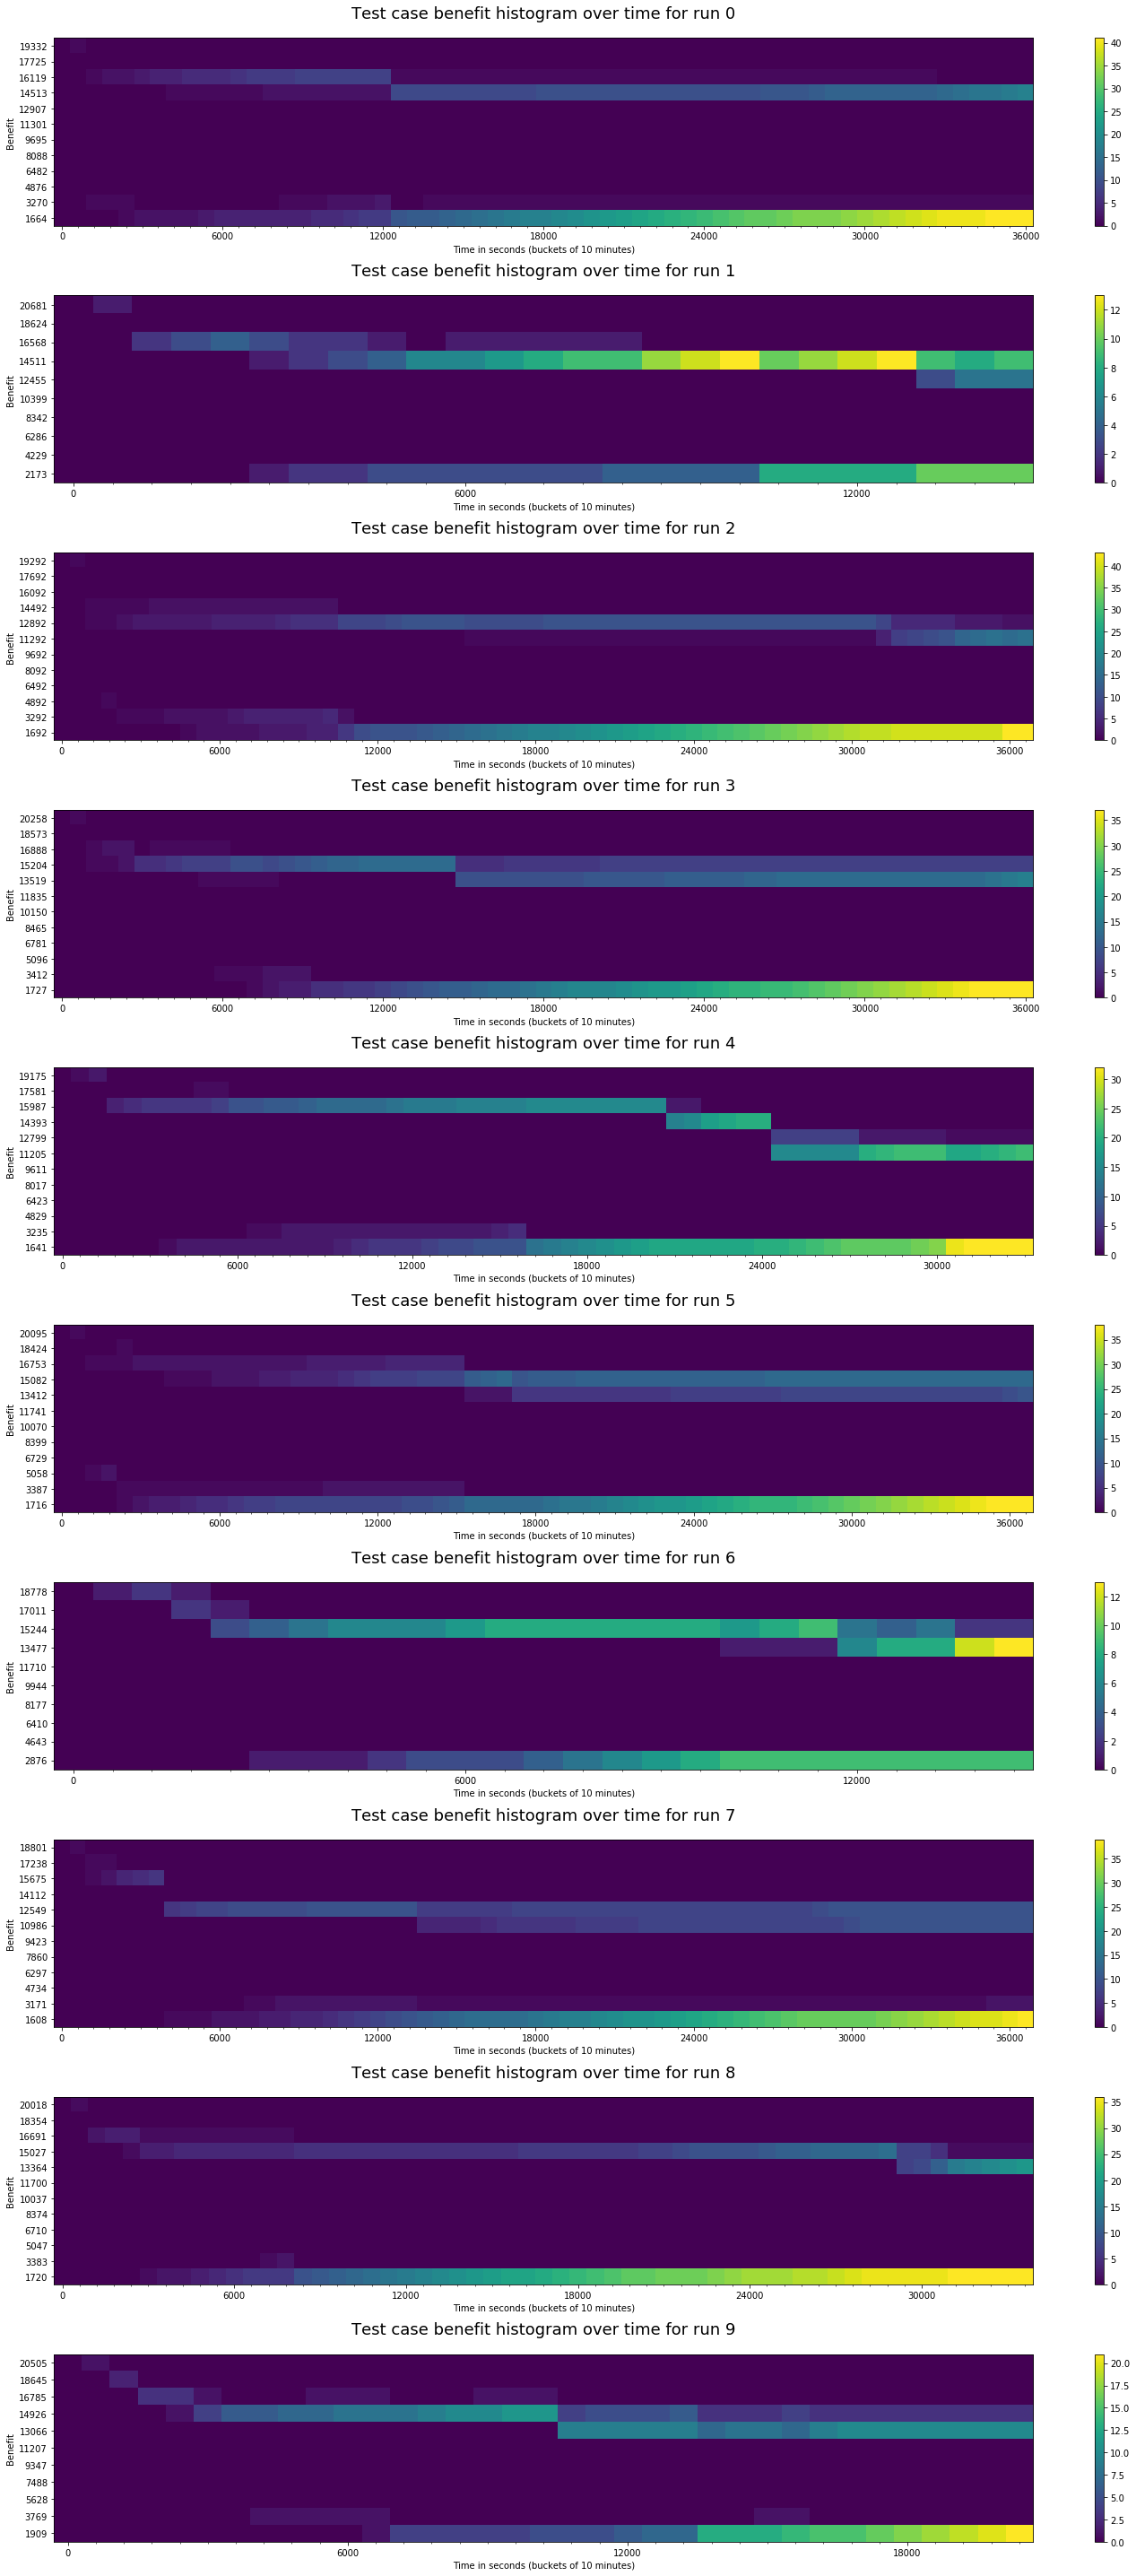

In [25]:
# plot histogram of test case benefit over time
def plot_benefit(data, fig, ax, bucket_size=10*60, bins='auto'):
    flattened = [y for r in data.values() for y in r]
    flattened_max = max(flattened)
    bin_edges = np.histogram_bin_edges(flattened, bins=bins)
    hists = np.zeros((len(bin_edges) - 1, 1))
    for row in data.values():
        hist, _ = np.histogram(row, range=(0, flattened_max), bins=bin_edges)
        hists = np.hstack([hists, np.vstack(hist)])
    hists = np.flip(hists, axis=0)
    c = ax.imshow(hists, aspect='auto', interpolation='nearest')
    fig.colorbar(c, ax=ax)
    ax.set_yticks(range(0, len(bin_edges)-1))
    ax.set_yticklabels(reversed([int(x) for x in bin_edges]))
    ax.set_ylabel('Benefit')
    data_keys = [0] + list(data.keys())
    xtick_labels = range(0, hists.shape[1], bucket_size // 60)
    ax.set_xticks(np.arange(0, hists.shape[1]), minor=True)
    ax.set_xticks(np.arange(0, hists.shape[1], bucket_size // 60))
    ax.set_xticklabels(map(lambda n: n*bucket_size, xtick_labels))
    ax.set_xlabel(f'Time in seconds (buckets of {bucket_size // 60} minutes)')

def plot_benefit_all(df):
    fig, axs = plt.subplots(df.shape[0])
    fig.set_size_inches(20, 40)
    for i, (run, ax) in enumerate(zip(df.itertuples(), axs)):
        ax.set_title(f'Test case benefit histogram over time for run {i}',
                     pad=22, fontsize=18)
        plot_benefit(run.benefits, fig, ax)
    fig.tight_layout()

plot_benefit_all(benefits)

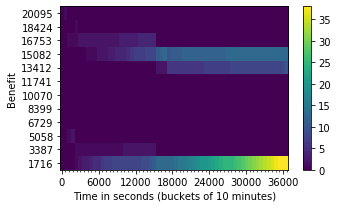

In [26]:
def plot_benefit_selected(n):
    case = list(benefits.itertuples())[n]
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 3)
    plot_benefit(case.benefits, fig, ax)
    fig.tight_layout()
    fig.savefig('benefit_histo_over_time_objdump.pdf')

plot_benefit_selected(5)